<a href="https://colab.research.google.com/github/Abdallahyx/Image-Segmentation-Using-U-Net-From-Scratch/blob/main/Image_segmentation_using_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Packages**

In [1]:
import os
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from glob import glob
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## **Download CityScapes Dataset**

In [2]:
# upload kaggle JSON file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d dansbecker/cityscapes-image-pairs

In [ ]:
!unzip cityscapes-image-pairs.zip

### **Preprocess The Data**

In [4]:
data_dir = os.path.join("cityscapes_data")
train_dir = os.path.join(data_dir, "train/") 
val_dir = os.path.join(data_dir, "val/")

image_paths = sorted(glob(train_dir + "*.jpg"))
height = 96
width = 128
images = np.zeros(shape=(len(image_paths), height, width, 3))
masks = np.zeros(shape=(len(image_paths), height, width, 3))

for i in tqdm(range(len(image_paths))):
    path = image_paths[i]
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = tf.keras.preprocessing.image.img_to_array(image).astype('float')
    img = image[:,:256,:]/255.0
    img = tf.image.resize(img,(height, width))
    mask = image[:,256:,:]/255.0
    mask = tf.image.resize(mask,(height, width))
    images[i] = img
    masks[i] = mask

100%|██████████| 2975/2975 [00:18<00:00, 157.84it/s]


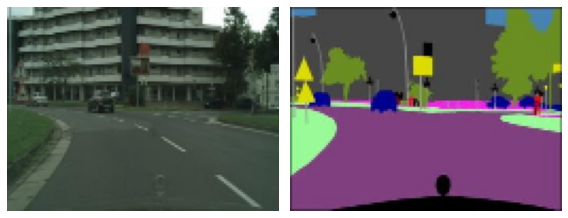

In [5]:
plt.figure(figsize=(8,25))
plt.subplot(1,2,1)
plt.imshow(images[0])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(masks[0])
plt.axis('off')  
plt.tight_layout()
plt.show()

### **RGB to Classes Model Using KMeans**

In [19]:
num_items = 5000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(5000, 3)
[[216   2  40]
 [138  20  99]
 [220 132 233]
 [ 48 226  57]
 [ 86 163 183]]


In [26]:
from sklearn.cluster import KMeans

num_classes = 10
masks_model = KMeans(n_clusters=num_classes)
masks_model.fit(color_array/255.0)

KMeans(n_clusters=10)

In [27]:
masks_model.predict(color_array[:5, :])

array([7, 1, 1, 1, 1], dtype=int32)

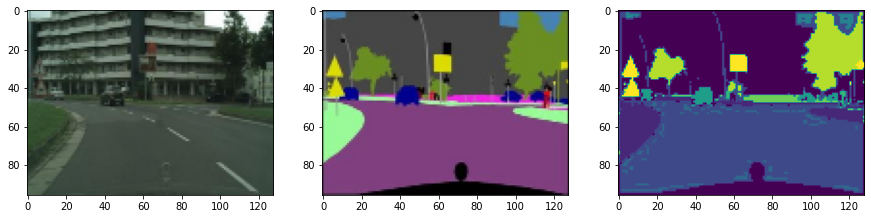

In [28]:
label_class = masks_model.predict(masks[0].reshape(-1, 3)).reshape(96, 128)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(images[0])
axes[1].imshow(masks[0])
axes[2].imshow(label_class)

In [40]:
mask_labels = np.array([masks_model.predict(mask.reshape(-1,3)).reshape(96,128) for mask in masks])

### **Split The Data**

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(images, mask_labels, test_size= 0.2) 

## **Build The Model**

In [43]:
import unet as UNet
height = 96
width = 128
n_channels = 3
model = UNet.unet_model((height, width, n_channels), n_classes=10)

In [ ]:
model.summary()

In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### **Train The Model**

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

callbacks =[
        ModelCheckpoint("UNet-Seg.h5", save_best_only=True)
]

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=50, callbacks=callbacks)

In [49]:
print(f"Accuray: {history.history['accuracy'][-1]}")
print(f"Val_Accuray: {history.history['val_accuracy'][-1]}")

Accuray: 0.9179477095603943
Val_Accuray: 0.8424111008644104


## **Evaluate The Model**

In [75]:
image_paths = sorted(glob(val_dir + "*.jpg"))
height = 96
width = 128
images = np.zeros(shape=(len(image_paths), height, width, 3))
masks = np.zeros(shape=(len(image_paths), height, width, 3))

for i in tqdm(range(len(image_paths))):
    path = image_paths[i]
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = tf.keras.preprocessing.image.img_to_array(image).astype('float')
    img = image[:,:256,:]/255.0
    img = tf.image.resize(img,(height, width))
    mask = image[:,256:,:]/255.0
    mask = tf.image.resize(mask,(height, width))
    images[i] = img
    masks[i] = mask


100%|██████████| 500/500 [00:03<00:00, 133.97it/s]


In [54]:
mask_labels = np.array([masks_model.predict(mask.reshape(-1,3)).reshape(96,128) for mask in masks])

In [93]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = tf.image.resize(pred_mask, [96,128])
    return pred_mask[:,:,0]

In [94]:
def show_image(image,title=None):
    plt.imshow(image)
    if title is not None: plt.title(title)
    plt.axis('off')

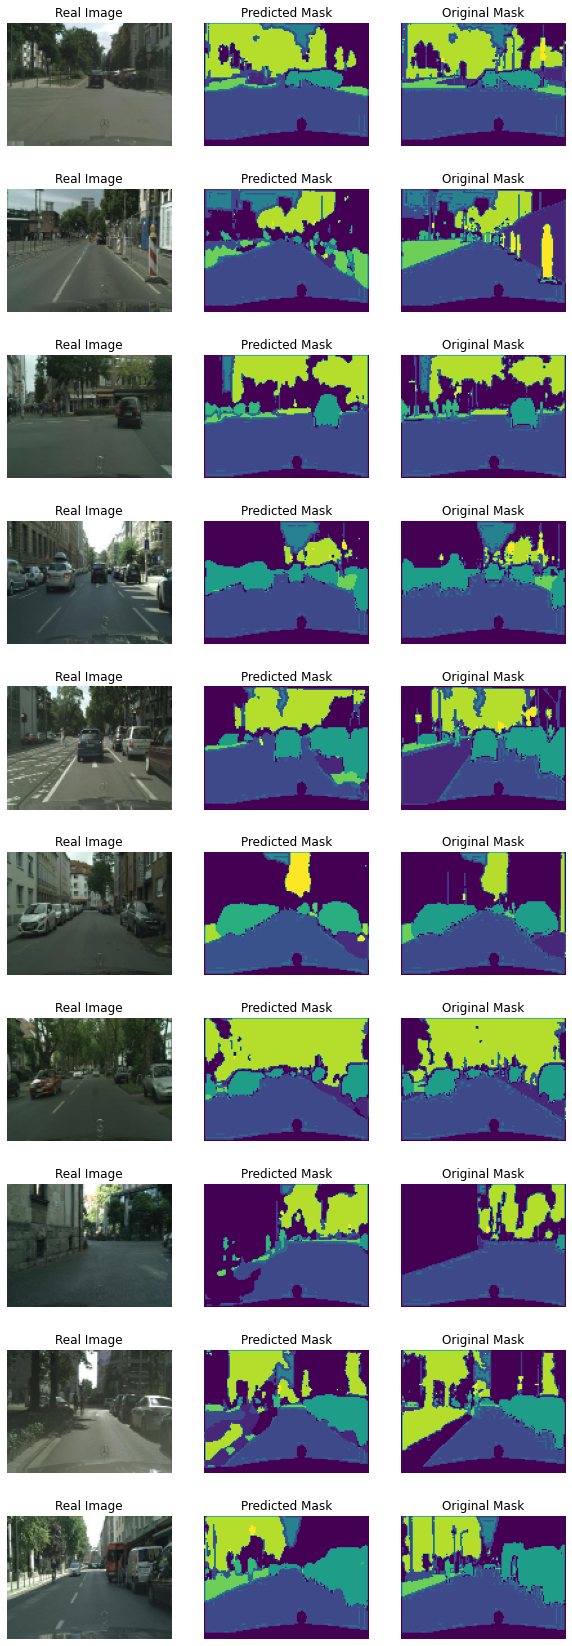

In [95]:
plt.figure(figsize=(10,30))
n=0
for i in range(1,31):
    plt.subplot(10,3,i)
    if n==0:
        id = np.random.randint(len(images))
        real_img = images[id][np.newaxis,...]
        pred_mask = model.predict(real_img)[0]
        pred_mask = create_mask(pred_mask)
        mask = mask_labels[id]
        show_image(real_img[0], title="Real Image")
        n+=1
    elif n==1:
        show_image(pred_mask, title="Predicted Mask")
        n+=1
    elif n==2:
        show_image(mask, title="Original Mask")
        n=0
plt.show()